# Notebook to setup the radcalnet_oc package

In [1]:

import os, shutil
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
rc = {"font.family": "serif",
      "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

plt.rcParams.update({'font.size': 18, 'axes.labelsize': 22})
import numpy as np
import xarray as xr
import pandas as pd

import radcalnet_oc as radoc
from radcalnet_oc import acutils
print(f'-radcalnet_oc: {radoc.__version__}')


-radcalnet_oc: 0.0.1


## Plot the solar extraterrestrial irradiance from different data sources (TSIS is recommended)

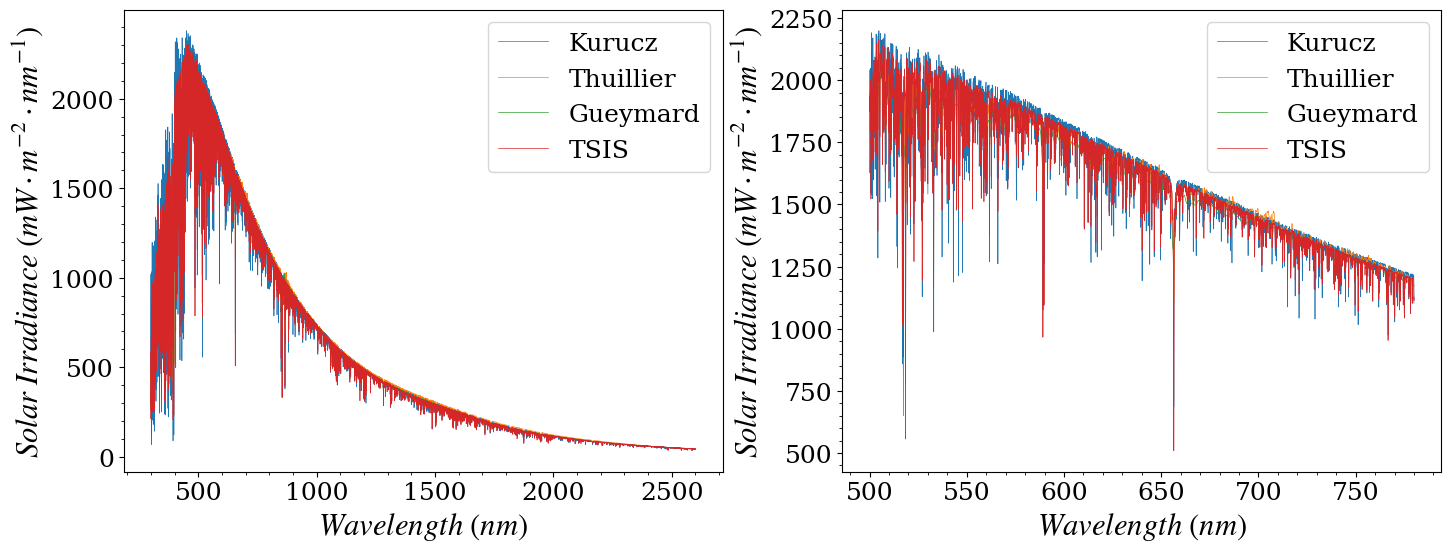

In [2]:
solar_irr=radoc.SolarIrradiance()
fig,axs = plt.subplots(1,2,figsize=(17,6))

solar_irr.kurucz.plot(lw=0.5,ax=axs[0],label='Kurucz')
solar_irr.thuillier.plot(lw=0.5,ax=axs[0],label='Thuillier')
solar_irr.gueymard.plot(lw=0.5,ax=axs[0],label='Gueymard')
solar_irr.tsis.plot(lw=0.5,ax=axs[0],label='TSIS')

axs[0].legend()

wl_range=slice(500,780)
solar_irr.kurucz.sel(wl=wl_range).plot(lw=0.5,ax=axs[1],label='Kurucz')
solar_irr.thuillier.sel(wl=wl_range).plot(lw=0.5,ax=axs[1],label='Thuillier')
solar_irr.gueymard.sel(wl=wl_range).plot(lw=0.5,ax=axs[1],label='Gueymard')
solar_irr.tsis.sel(wl=wl_range).plot(lw=0.5,ax=axs[1],label='TSIS')
axs[1].legend()

for ax in  axs:
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.set_ylabel(r'$Solar\ Irradiance\ (mW\cdot m^{-2}\cdot nm^{-1})$')
    ax.minorticks_on()
    #ax.semilogy()

## Check impact of the spectral resolution (sensor-like)
Spectral resolution is defined by the number (central wavelength: `central_wl`) and width (gaussian distribution) of spectral bands recorded. The gaussian distribution are computed from the full width at half maximum `fwhm` given in nanometers.

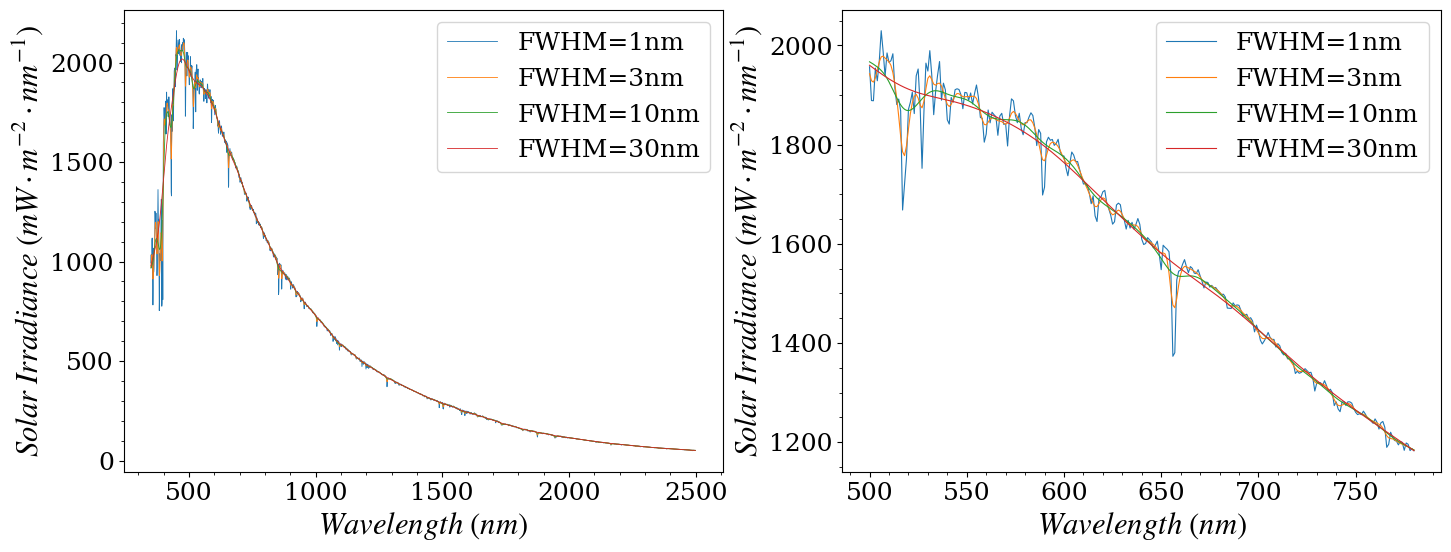

In [3]:

spectral_res=1
central_wl=np.arange(350,2500,spectral_res)

signal = solar_irr.tsis
wl_signal = solar_irr.tsis.wl.values

fig,axs = plt.subplots(1,2,figsize=(17,6))
wl_range=slice(500,780)
for fwhm in [1,3,10,30]:    
    spectral=radoc.Spectral(central_wl,fwhm)
    F0 = spectral.convolve(signal)
    F0.plot(lw=0.6,label='FWHM='+str(fwhm)+'nm',ax=axs[0])
    F0.sel(wl=wl_range).plot(lw=0.8,label='FWHM='+str(fwhm)+'nm',ax=axs[1])

for ax in  axs:
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.set_ylabel(r'$Solar\ Irradiance\ (mW\cdot m^{-2}\cdot nm^{-1})$')
    ax.minorticks_on()  
    ax.legend()

## Computation of the top and bottom of atmosphere values

In [4]:
# set Sun zenith angle 
sza=45
# set aerosol optical thickness
aot550=0.1
# tcwv cm into kg.m-2
tpw_cm=2.6
tcwv=tpw_cm*10 

to3_du=300 
pressure=1000

# conversion O3 du to kg.m-2
tco3=to3_du *6.4286e-3/300
tcno2=3e-6/100
tcch4= 1e-2

In [5]:
lut= radoc.LUT(wl=np.arange(350, 2500, 1))
lut.load_auxiliary_data()
lut.lut_preparation(sza=[sza])
gas_trans = radoc.GaseousTransmittance(lut.gas_lut)

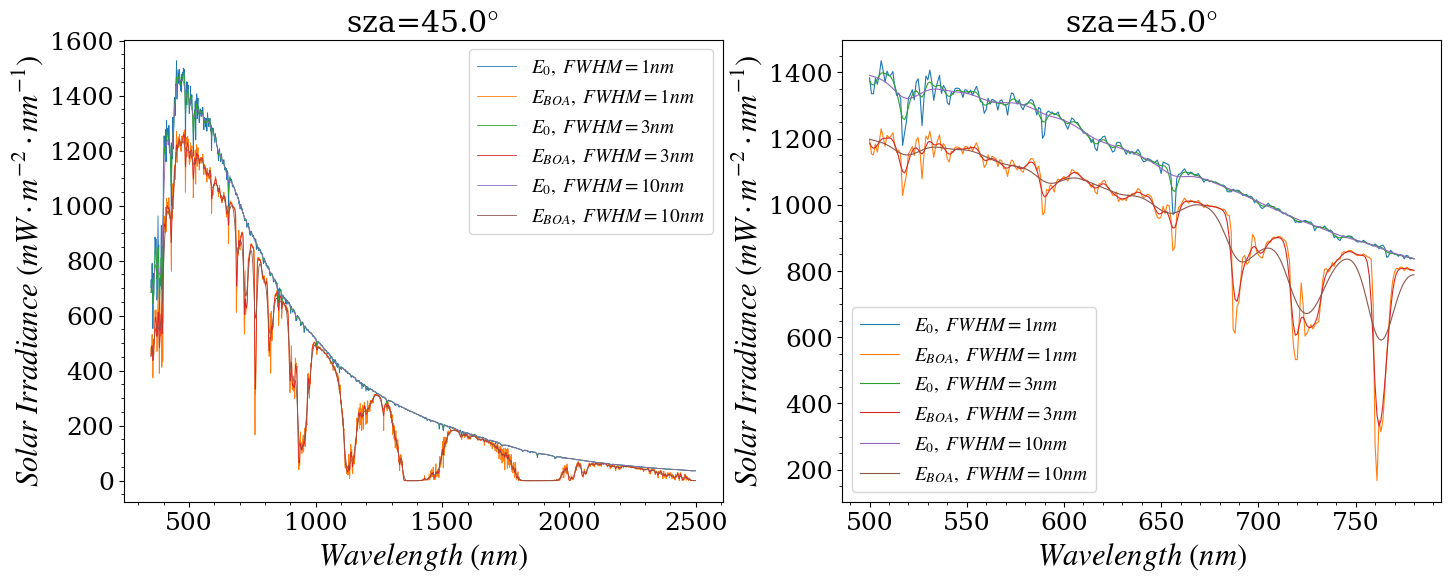

In [6]:
solar_irr=radoc.SolarIrradiance()
fwhm=30.
sza=45
mu0 = np.cos(np.radians(sza))
spectral_res=1
central_wl=np.arange(350,2500,spectral_res)
wl_range=slice(500,780)

Taero_mol = lut.trans_lut.Ttot_Ed.isel(wind=1).interp(sza=sza).isel(model=1).interp(aot_ref=aot550,method='quadratic').interp(wl=central_wl,method='quadratic')

gas_trans.air_mass=1./mu0

gas_trans.coef_abs_scat['h2o'] = 1
gas_trans.coef_abs_scat['ch4'] = 1
Ttot=gas_trans.get_gaseous_transmittance()

fig,axs = plt.subplots(1,2,figsize=(17,6))
for fwhm in [1,3,10]:    
    spectral=radoc.Spectral(central_wl,fwhm)
    F0 = spectral.convolve(solar_irr.tsis)*mu0
    Tg = spectral.convolve(Ttot)
    F0.plot(lw=0.6,label=r'$E_{0},\ FWHM='+str(fwhm)+r'nm$',ax=axs[0])
    F0.sel(wl=wl_range).plot(lw=0.8,label=r'$E_{0},\ FWHM='+str(fwhm)+r'nm$',ax=axs[1])
    Ed=Taero_mol*F0*Tg
    Ed.plot(lw=0.6,label=r'$E_{BOA},\ FWHM='+str(fwhm)+r'nm$',ax=axs[0])
    Ed.sel(wl=wl_range).plot(lw=0.8,label=r'$E_{BOA},\ FWHM='+str(fwhm)+r'nm$',ax=axs[1])
for ax in  axs:
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.set_ylabel(r'$Solar\ Irradiance\ (mW\cdot m^{-2}\cdot nm^{-1})$')
    ax.minorticks_on() 
    ax.set_title('sza={:.1f}'.format(sza)+r'$\degree$')
    ax.legend(fontsize=14)